<a href="https://colab.research.google.com/github/CthulhuCoder01/rnn-model-to-check-country-by-name/blob/main/Name_Country_Modal_RNN_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://download.pytorch.org/tutorial/data.zip


--2023-06-02 06:14:27--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.222.139.21, 52.222.139.109, 52.222.139.59, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.222.139.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.07s   

2023-06-02 06:14:27 (36.8 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [3]:
!unzip *.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


 # This is a multiclass clasification as there are so many diffrent names

In [4]:
import os
import numpy as np
import unicodedata
import string

import torch
import torch.nn as nn



In [5]:

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


In [6]:

def unicodeToAscii(s):
  return ''.join(
      # Here we used a filtered generato expression to create an array of c fromo
      # normalised cahrated using NFD format then check is they have any non space mark if not
      #then add its value if yes then check is characted is present in all_letter 
      # then showit
      c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn'and c in all_letters
  )



In [7]:
all_names = []
all_country = []

In [8]:

for f in  os.listdir('/content/data/names'):
    fl = open("/content/data/names/"+f, "r")
    lis = fl.readlines()
    clean_lis = list(map(unicodeToAscii,lis))
    all_names.extend(clean_lis)
    country_name = f.split(".")[0]
    all_country.extend( [ country_name ]  * len(clean_lis) )



In [9]:
n_rows = len(all_names)

Now Comes One Hot Embedding to generate input for RNN model

In [11]:
# This emb is identity matrix of size n_letters x n_letters
emb = torch.eye(n_letters)
#mapping is done this way becuse maye all elemtns are unique to get range of all
#zipfunction map two array with their coresponding array to get a zip interablw with common value
mapzip = zip(np.unique(all_country), range(n_rows))
# And dict convert them into ket valu pair
mapping = dict(mapzip)


## Converting name into char

In [19]:
def get_data(idx):
  name = all_names[idx]
  country = all_country[idx]
  name_char_lis = np.array(list(name))
  # Search through the np array name-charlist then convert it to a column array then 
  # Find index of letters from whole letter  porpose to get numerical value
  indices = np.where(name_char_lis[..., None] == np.array(list(all_letters)))[1]
  # Now we will get country code as in form of tensor and all indices in
  # Form of numpy array in form of embeded with one hot encodin
  # print(indices)
  # Now as emb has n_letters of charaters here hot encoding based on all charaters not max
  # chereter here
  # Here mapping is country dict we created earlies with all unique country
  return emb[torch.from_numpy(indices)], torch.tensor(mapping[country])



In [18]:
name = "Cthulhu"
country = "Pacific"
name_char_list = np.array(list(name))

column_array = name_char_list[..., None]
row_array = name_char_list[None,...]
column_array_reshape = name_char_list.reshape(-1, 1)
row_array_reshape = name_char_list.reshape(1, -1)

print(column_array)
print(row_array)
print(column_array_reshape)
print(row_array_reshape)



[['C']
 ['t']
 ['h']
 ['u']
 ['l']
 ['h']
 ['u']]
[['C' 't' 'h' 'u' 'l' 'h' 'u']]
[['C']
 ['t']
 ['h']
 ['u']
 ['l']
 ['h']
 ['u']]
[['C' 't' 'h' 'u' 'l' 'h' 'u']]


RNN(57, 114)


## Here we will define an RNN 

In [30]:
class Net(nn.Module):

  def __init__(self, n_country, n_letters):
    super(Net, self).__init__()
    self.rnn = nn.RNN(n_letters, 2 * n_letters)
    # This is last layer multiplication for outcome with n_country instead of 1 because of
    # multilevel Nural network
    #Shape of linear modal
    self.fc = nn.Linear(2 * n_letters, n_country)

  def forward(self,x):
    out, _ = self.rnn(x)
    # Now take value from last step of rnn using out[-1,:] and give result to user
    out1 = self.fc(out[-1,:])
    return out1



In [31]:

n_countries = len(np.unique(all_country))
model = Net(n_country=n_countries, n_letters=n_letters)



In [32]:
print(model)

Net(
  (rnn): RNN(57, 114)
  (fc): Linear(in_features=114, out_features=18, bias=True)
)


In [33]:
# Loss function i.e Cross Entropy loss function
loss_fn = nn.CrossEntropyLoss()
# Gradient Desent
#Model.parametrs() give all learnable parameters of an object wwith include weight,baises of 
# RNN and fully conected layes
optimizer = torch.optim.SGD(model.parameters(), lr= 0.005)


In [34]:
print(loss_fn)
print(optimizer)

CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.005
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [35]:
num_epochs = 30
all_losses = []
for epoch in range(num_epochs):
  arr = np.arange(n_rows) # 0, 1, --- 20074
  np.random.shuffle(arr) # shuffle it
  epoch_loss = 0
  for ind in arr:
    data, target = get_data(ind) # data is indices vector in one hot form and target in tensor of country code
    output = model(data)
    # This will use cross entropy loss function to calculate loss
    loss = loss_fn(output, target)
    epoch_loss += loss.detach().numpy()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  all_losses.append(epoch_loss)


[26502.498393927963, 20294.360917980084, 18432.45701490254, 17275.903471956743, 16285.467480631414, 15464.807541737475, 14618.547813242263, 13965.637842594699, 13426.210528819125, 12856.046646130804, 12641.418919241942, 12068.77853090975, 11863.02244802778, 11568.70746293061, 11255.918768301517, 11052.544018700792, 10660.4760283457, 10569.827331080734, 10578.588332689624, 10434.624368269211, 10285.67197601474, 10175.56277152752, 9820.974140908522, 9967.157308442593, 9989.343314846574, 10239.171294479238, 9869.255883548338, 9871.427258814641, 9808.602932142812, 9823.905956978535]


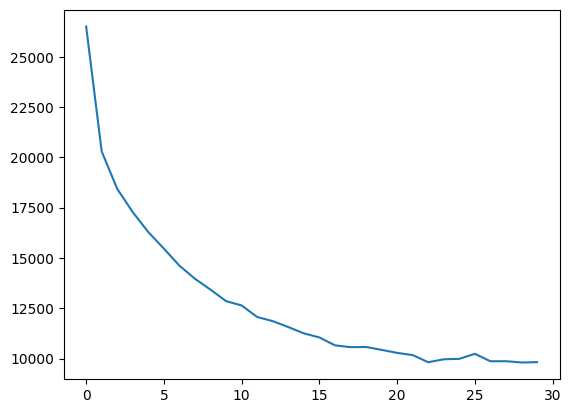

In [36]:
import matplotlib.pyplot as plt
# We can also live plot the neural network to get its value
plt.plot(all_losses)
print(all_losses)


In [37]:
def textToLinear(name):
  name_char_lis = np.array(list(name))
  indices = np.where(name_char_lis[..., None] == np.array(list(all_letters)))[1]
  return emb[torch.from_numpy(indices)]


In [40]:


# This uses tensors ans input
data, target = get_data(100)
# nameTensor = get_data(10)
output =  model(data)
predicted_labels = output.argmax()
correct_predictions = (predicted_labels == target)
# print("Predicted labels:", predicted_labels)
# print("Target labels:", target)

accuracy = torch.mean(correct_predictions.float())

print("Accuracy:", accuracy.item())

Accuracy: 1.0


## Now Ploting Evaluation of results

In [ ]:


#Take 10000 values randomize them feed data to model get result 
# Cheaack how close is the result to data then give value  



